# Clasificación de sentimientos en reseñas de películas con Machine Learning

## Contenido

* [Introducción](#intro)  
* [1. Descripción y preparación de los datos](#data_review)  
* [2. Análisis exploratorio de los datos](#data_analysis)  
* [3. Preprocesamiento de los datos para los modelos](#preprocess)
* [4. Entrenamiento de los modelos](#models)  
    * [4.1. Modelo 0 - Constante](#m-0)  
    * [4.2. Modelo 1 - NLTK, TF-IDF y LR](#m-1)  
    * [4.3. Modelo 2 - spaCy, TF-IDF y LR](#m-2)  
    * [4.4. Modelo 3 - spaCy, TF-IDF y LGBMClassifier](#m-3)  
    * [4.5. Modelo 4 - BERT y LightGBM](#m-4)
* [5. Pruebas adicionales para los modelos](#test)  
    * [5.1. Modelo 1](#t-1)  
    * [5.2. Modelo 2](#t-2)
    * [5.3. Modelo 3](#t-3)
    * [5.4. Modelo 4](#t-4)
* [Conclusiones](#end)  

## Introducción <a id='intro'> </a>

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, se utilizará un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## 1. Descripción y preparación de los datos. <a id='data_review'> </a>

In [1]:
# Importamos las librerías para el análisis de datos
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.style.use('seaborn')

In [ ]:
# Para usar progress_apply
tqdm.pandas()

In [4]:
# Importando los datos y revisando sus primeras lineas
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [5]:
# Información general de las columnas
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
# Estadisticas descriptivas de las características numericas
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [7]:
# Estadisticas descriptivas de las columnas categoricas
df_reviews.describe(include='object')

,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0926129,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796


In [8]:
# Revisión de duplicados básica
df_reviews[df_reviews.duplicated()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx


Las columnas y sus datos parecen coherentes, no hay evidencias de datos nulos, ni de columnas con tipos de datos conflictivos. Una posible mejora en el tipado de datos es la columna runtime_minutes que funcionaría mejor como tipo int64, sin embargo, el enfoque de los modelos que entrenaremos no utilizará estas columnas, por lo que no será trabajada en este proyecto.

## 2. Análisis exploratorio de los datos. <a id="data_analysis"></a>

Veamos el número de películas y reseñas a lo largo de los años.

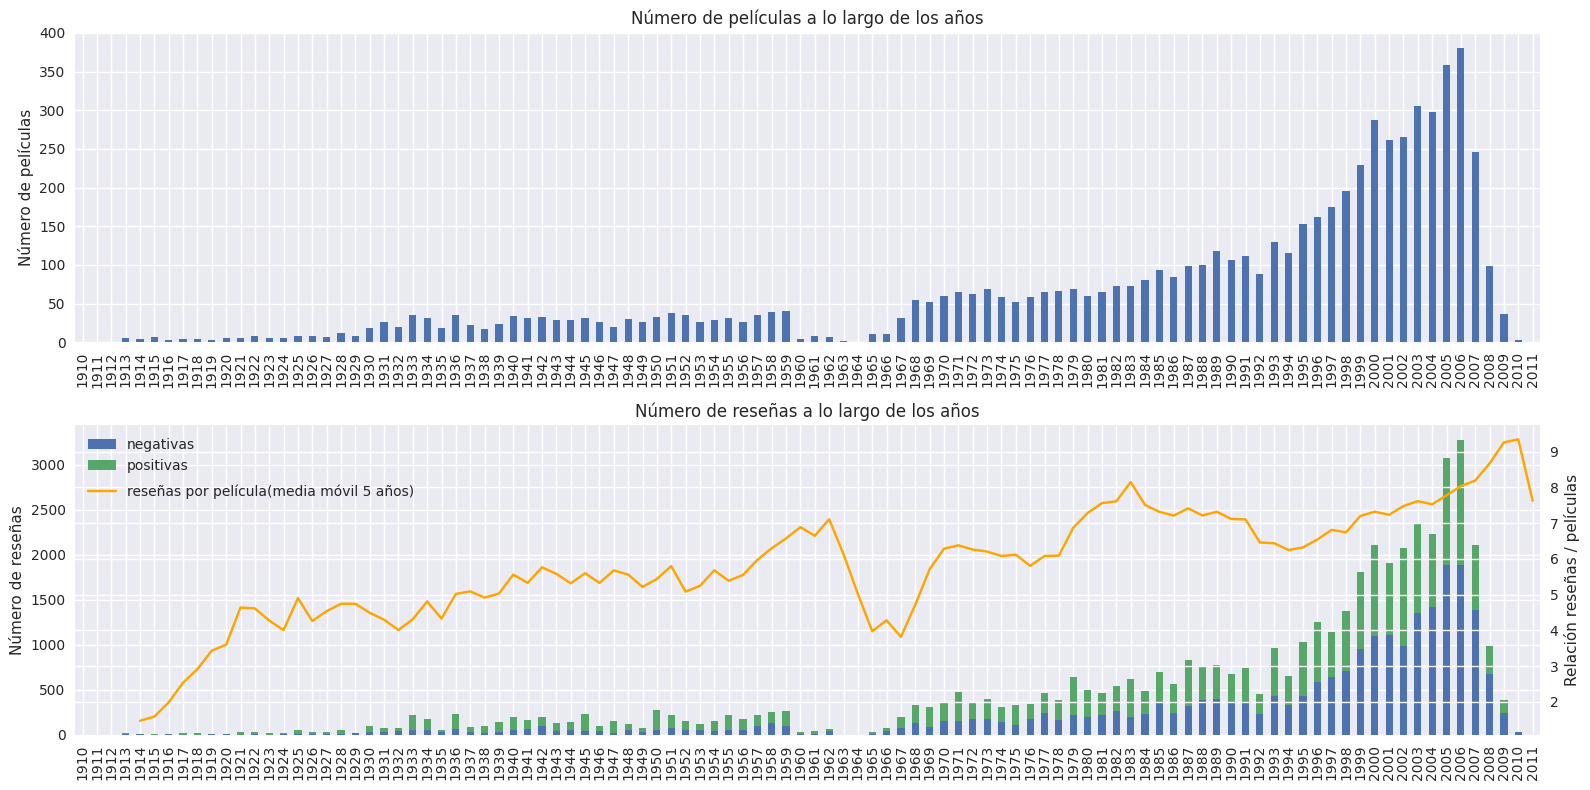

In [9]:
# Visualización temporal del lanzamiento de peliculas y reseñas
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Peliculas
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(1910, max(dft1.index.max(), 2012))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')
ax.set_ylabel('Número de películas')

# Reseñas
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(1910, max(dft2.index.max(), 2012))).fillna(0)
dft2.columns = ['negativas', 'positivas']
dft2.plot(kind='bar', stacked=True, ax=ax)

ax.legend(loc='upper left')
ax.set_xlabel('')
ax.set_ylabel('Número de reseñas')

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(1910, max(dft2.index.max(), 2012))).fillna(0)
dft3 = (dft2/dft1).fillna(0)

axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reseñas por película(media móvil 5 años)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
axt.legend(lines, labels, loc='upper left', bbox_to_anchor=(0, 0.85))
ax.set_title('Número de reseñas a lo largo de los años')
axt.set_ylabel('Relación reseñas / películas')

fig.tight_layout()

A medida que los años incrementan, también evidenciamos un incremento en el número de películas realizadas, con algunas estacionalidades entre años, probablemente debido al tiempo que toma su desarrollo. Las reseñas están directamente correlacionadas con estas, sin embargo, el incremento de reseñas ha ido aumentando más en relación con el de películas a través del tiempo.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto).

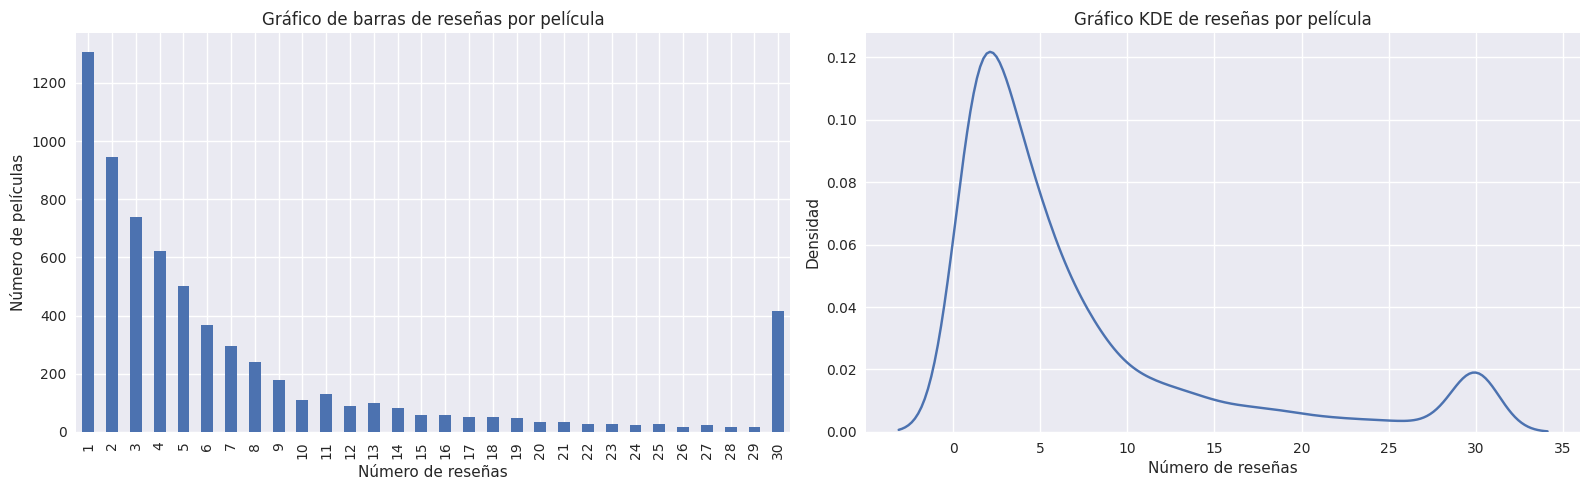

In [10]:
# Visualización de reseñas por pelicula
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de barras
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de reseñas por película')
ax.set_xlabel('Número de reseñas')
ax.set_ylabel('Número de películas')

# Gráfico KDE
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de reseñas por película')
ax.set_xlabel('Número de reseñas')
ax.set_ylabel('Densidad')

fig.tight_layout()

Hay una distribución en la que la mayoría de películas tienen alrededor de 3 reseñas; sin embargo, hay un grupo destacado de películas que posee 30. Este grupo puede referirse no solo a las películas con 30 reseñas, sino a todas las películas con al menos 30 o más reseñas y que el dataset limite a solo 30 reseñas por película, a pesar de disponer de más. Esto explicaría la diferencia tan marcada con sus grupos vecinos.

In [11]:
# Balance de clases objetivo
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

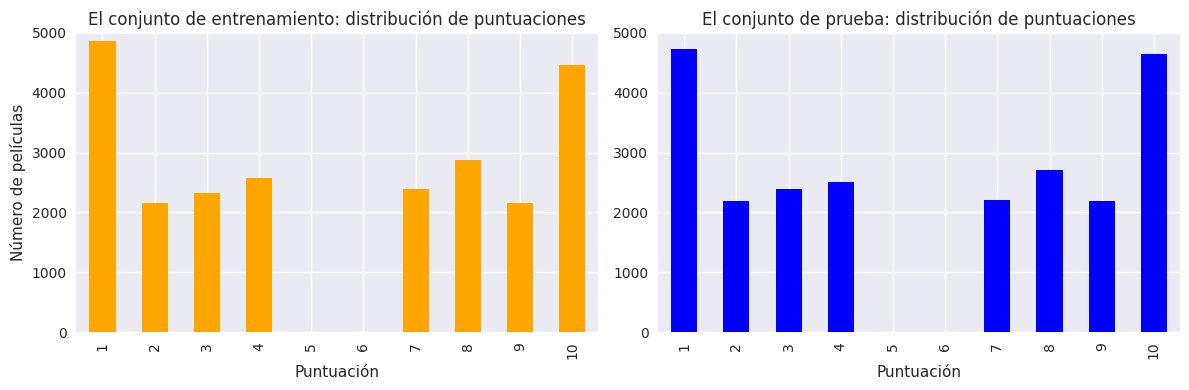

In [12]:
# Visualización de rating de las películas por conjunto de entrenamiento y pruebas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Conjunto de entrenamiento
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax, color='orange')
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')
ax.set_xlabel('Puntuación')
ax.set_ylabel('Número de películas')

# Conjunto de pruebas
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax, color='blue')
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')
ax.set_xlabel('Puntuación')

fig.tight_layout()

Tenemos una distribución del objetivo muy bien balanceada. Además, su distribución de puntuaciones es muy similar tanto en el conjunto de entrenamiento como en el de pruebas, por lo que la calidad percibida de las películas en los dos conjuntos es similar.

Analicemos la distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos.

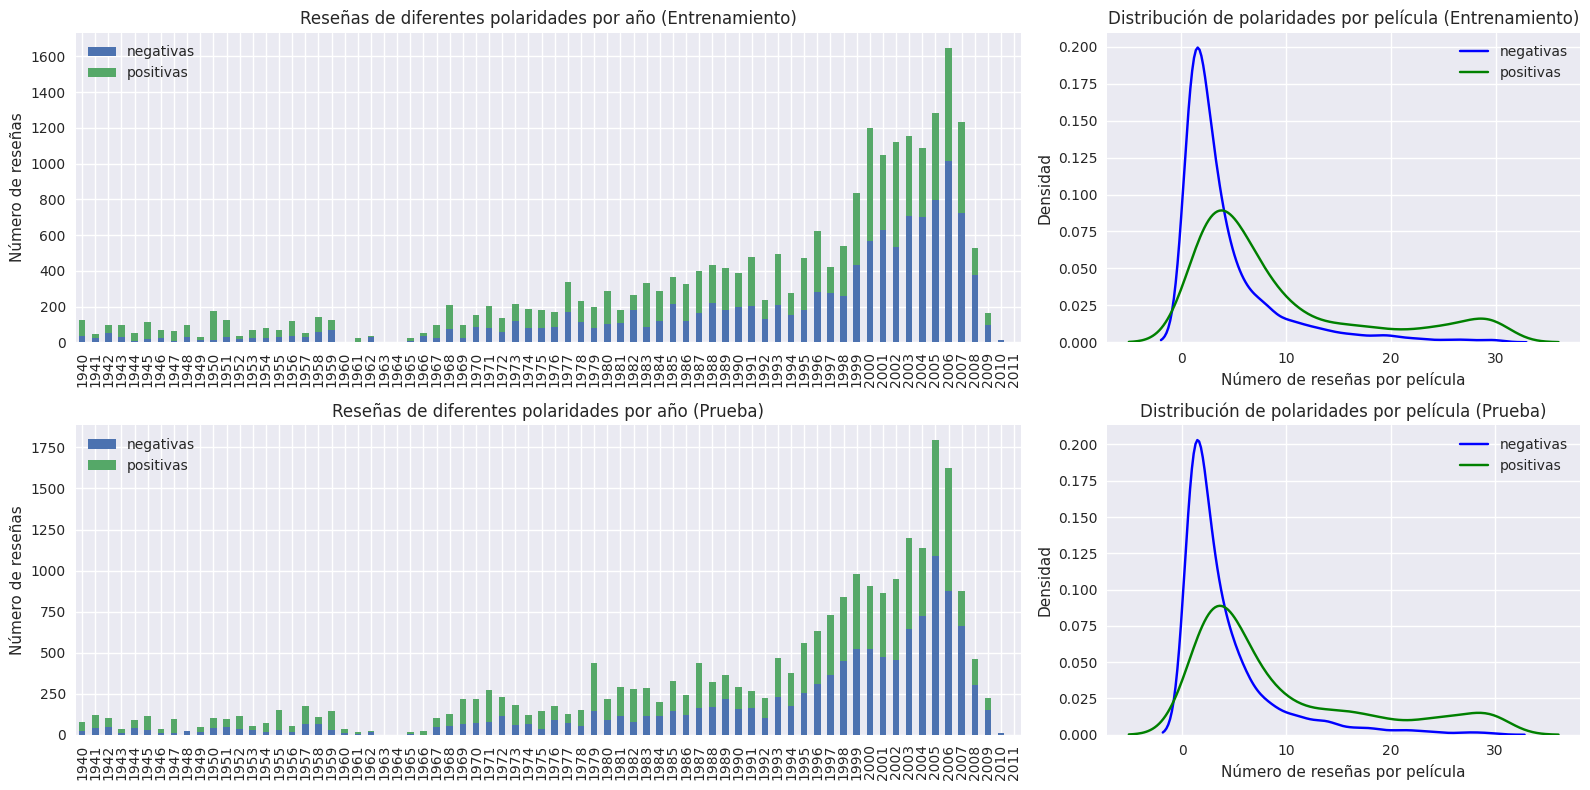

In [13]:
# Visualización de la distribución del balance del objetivo en el tiempo por conjunto de entrenamiento y pruebas
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Conjunto de entrenamiento
    # Barplot
ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft.columns = ['negativas', 'positivas']
dft = dft.reindex(index=np.arange(1940, max(dft.index.max(), 2012))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Reseñas de diferentes polaridades por año (Entrenamiento)')
ax.legend(loc='upper left')
ax.set_xlabel('')
ax.set_ylabel('Número de reseñas')

    # KDE
ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negativas', ax=ax)
sns.kdeplot(dft[1], color='green', label='positivas', ax=ax)
ax.legend()
ax.set_title('Distribución de polaridades por película (Entrenamiento)')
ax.set_xlabel('Número de reseñas por película')
ax.set_ylabel('Densidad')

# Conjunto de pruebas
    # Barplot
ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft.columns = ['negativas', 'positivas']
dft = dft.reindex(index=np.arange(1940, max(dft.index.max(), 2012))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Reseñas de diferentes polaridades por año (Prueba)')
ax.legend(loc='upper left')
ax.set_xlabel('')
ax.set_ylabel('Número de reseñas')

    # KDE
ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negativas', ax=ax)
sns.kdeplot(dft[1], color='green', label='positivas', ax=ax)
ax.legend()
ax.set_title('Distribución de polaridades por película (Prueba)')
ax.set_xlabel('Número de reseñas por película')
ax.set_ylabel('Densidad')

fig.tight_layout()

La distribución de reseñas negativas y positivas por año y por película es muy similar entre los conjuntos de entrenamiento y prueba, lo cual indica que ambos conjuntos están bien balanceados respecto a la variable objetivo (pos).

Además, se observa que las películas con una menor cantidad de reseñas tienden a recibir una mayor proporción de reseñas negativas. En contraste, las películas con más reseñas suelen tener distribuciones más equilibradas, con una ligera predominancia de reseñas positivas en varios casos.

## 3. Preprocesamiento de los datos para los modelos. <a id='preprocess'></a>

Desarrollamos una rutina de evaluación que se pueda usar para todos los modelos en este proyecto.

In [42]:
# Definición de una función para evaluar los modelos a través de diferentes métricas
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)
    
    return df_eval_stats

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [15]:
# Normalización de los textos de reseñas
df_reviews['review_norm'] = df_reviews['review'].str.lower()

def clean_review_texts(text):    
    pattern = r"[^A-Za-z']"
    text = re.sub(pattern, ' ', text)
    text_arr = text.split()
    text = ' '.join(text_arr)

    return text

df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x:clean_review_texts(x))
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
# Segmentación del conjunto en entrenamiento y pruebas
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Selección de características y objetivos
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


Para este proyecto usaremos como única fuente de características las reseñas de los usuarios, ya que nuestro objetivo es realizar un análisis de sentimiento basado en ellas.

## 4. Entrenamiento de los modelos. <a id='models'></a>

### 4.1. Modelo 0 - Constante. <a id='m-0'></a>

Nuestro modelo 0 corresponderá a un modelo de cordura que nos permitirá comparar el desempeño del resto de modelos y descartar aquellos que no superen su desempeño.

In [17]:
# Entrenamiento de modelo dummy
from sklearn.dummy import DummyClassifier

model_0 = DummyClassifier(strategy='constant', constant=0)
model_0.fit(train_features, train_target)

DummyClassifier(constant=0, strategy='constant')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


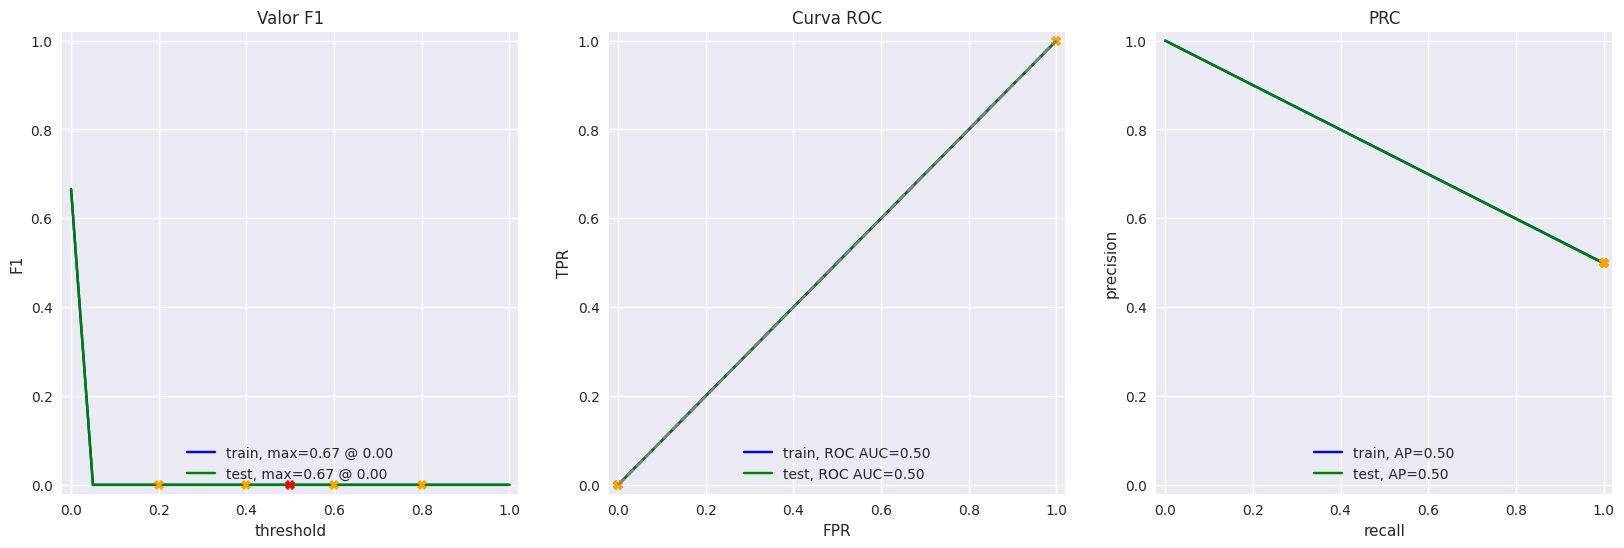

In [18]:
# Evaluación de desempeño de modelo 0: dummy
model_0_results = evaluate_model(model_0, train_features, train_target, test_features, test_target)

### 4.2. Modelo 1 - NLTK, TF-IDF y LR. <a id='m-1'></a>

El modelo 1 será un modelo de regresión logística en el que las características serán formadas por vectores TF-IDF. Estos vectores se formarán a partir de las reseñas normalizadas ya existentes y el descarte de las palabras vacías usando la librería nltk.corpus.stopwords.

In [19]:
# Importando las librerías para el modelo 1
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [20]:
# Seleccionando el corpus de los conjuntos
train_corpus = df_reviews_train['review_norm']
test_corpus = df_reviews_test['review_norm']

# Identificando las palabras vacias (inglés)
stop_words_set = set(stopwords.words('english'))

# Instanciando y entrenando el vectorizador TF-IDF
count_tf_idf = TfidfVectorizer(stop_words=stop_words_set)
tf_idf = count_tf_idf.fit_transform(train_corpus)

# Preparando las características de cada conjunto del modelo 1
train_features_1 = tf_idf
test_features_1 = count_tf_idf.transform(test_corpus)

# Entrenando el modelo de regresión logística
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


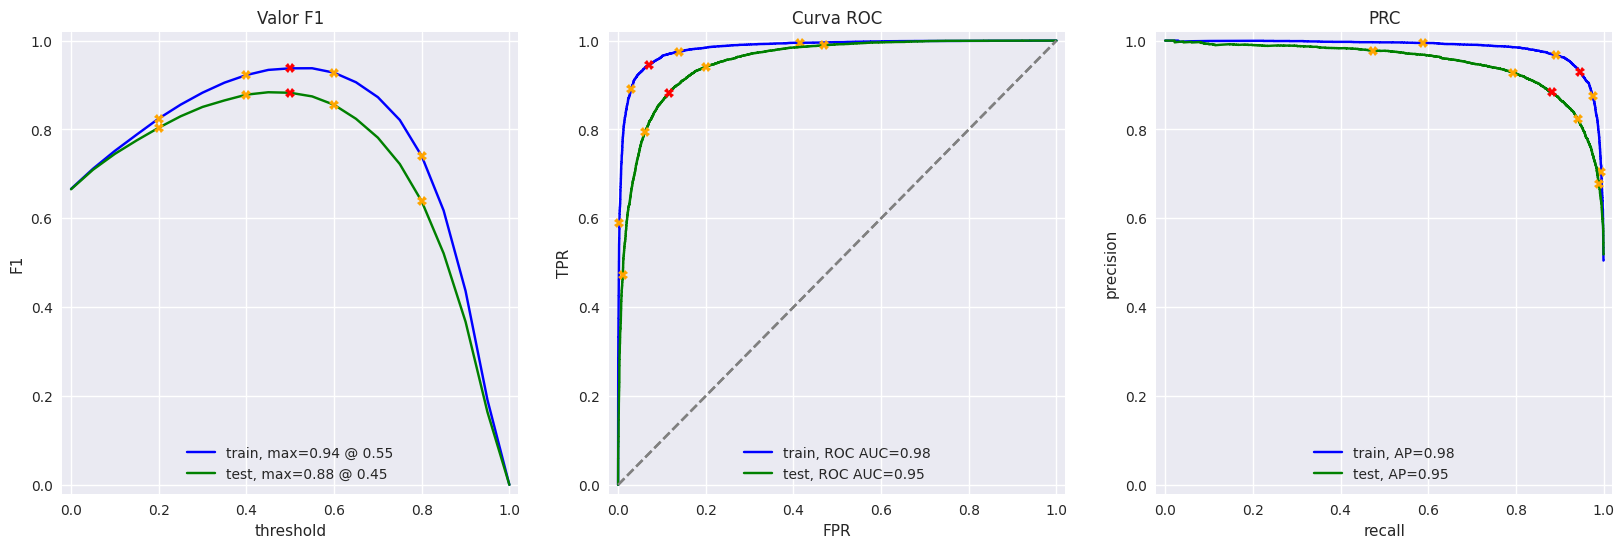

In [21]:
# Evaluación de desempeño del modelo 1: NLTK, TF-IDF y LR
model_1_results = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

El modelo tiene un rendimiento muy sólido tanto en entrenamiento como en prueba con métricas por encima de 0.88 en todos los casos. Muestra una ligera señal de sobreajuste (6 puntos de F1 y Accuracy), pero sigue siendo muy confiable y generalizable.

Las métricas F1, ROC-AUC y APS en el conjunto de prueba (0.88-0.95) sugieren que el modelo equilibra bien precisión y recall, y tiene excelente capacidad para separar clases.

Se puede considerar ajustar el umbral de decisión a 0.45 para maximizar el F1 y además mantener un buen desempeño en las otras métricas.

### 4.3 Modelo 2 - spaCy, TF-IDF y LR. <a id='m-2'></a>

El modelo 2 será un modelo de regresión logística también, con características formadas por vectores TF-IDF. Estos vectores se formarán a partir de las reseñas normalizadas ya existentes; sin embargo, se tokenizaran previamente a partir del lematizado con descarte de palabras vacías usando la librería spaCy.

In [22]:
# Importando las librerías faltantes para el modelo
import spacy

In [23]:
# Definiendo la lematización sin palabras vacias con spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_2(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [24]:
# Instanciando y entrenando el vectorizador TF-IDF con el preproceso de lematización
count_tf_idf_2 = TfidfVectorizer(preprocessor=text_preprocessing_2)
tf_idf_2 = count_tf_idf_2.fit_transform(train_corpus)

# Preparando las características de cada conjunto del modelo 2
train_features_2 = tf_idf_2
test_features_2 = count_tf_idf_2.transform(test_corpus)

# Entrenando el modelo de regresión logística
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


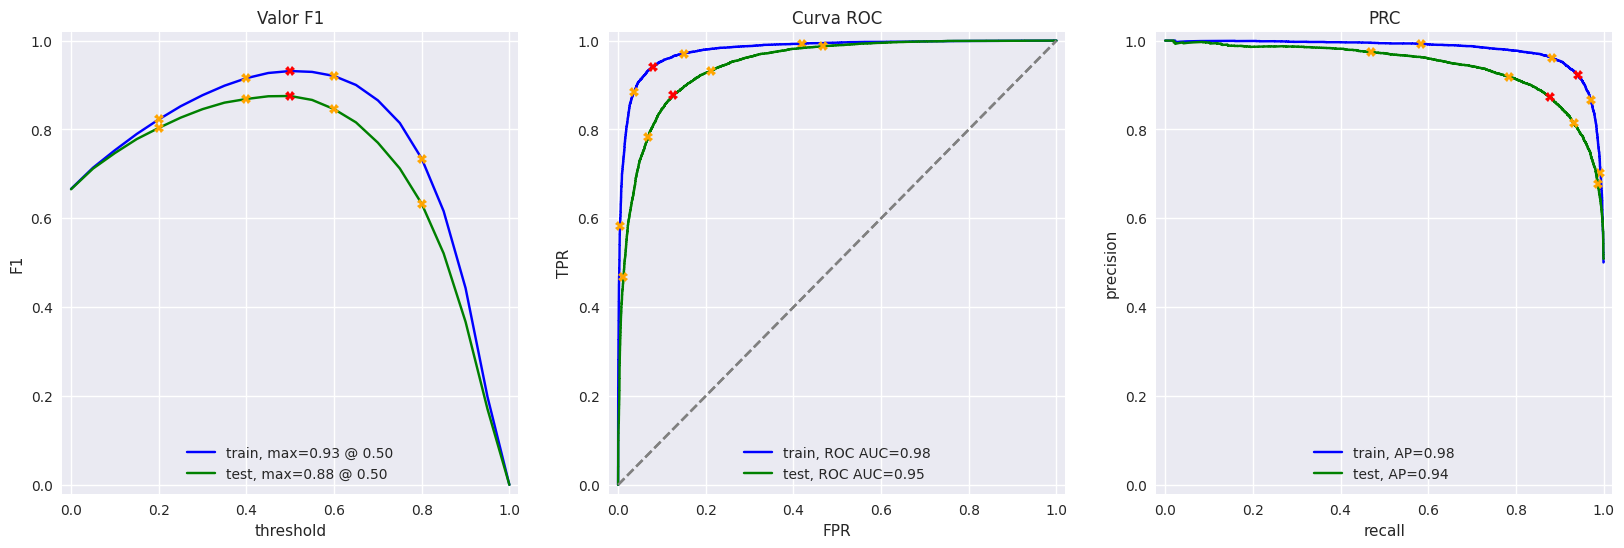

In [25]:
# Evaluación de desempeño del modelo 2: spaCy, TF-IDF y LR
model_2_results = evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

El modelo 2 es bastante similar al modelo 1 en desempeño, existen algunas distinciones como un umbral en 0.5 para optimizar las métricas, por lo que no es necesario una modificación del mismo y un sobreajuste ligeramente menor que prácticamente no afecta las métricas del conjunto de pruebas.

### 4.4. Modelo 3 - spaCy, TF-IDF y LGBMClassifier. <a id='m-3'></a>

Para el modelo 3 usaremos la misma base de construcción de características utilizadas en el modelo 2, sin embargo, utilizaremos un modelo clasificador LightGBM.

In [26]:
# Importamos el nuevo modelo
from lightgbm import LGBMClassifier

In [27]:
# Entrenando el modelo de LightGBM
model_3 = LGBMClassifier()

model_3.fit(train_features_2, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


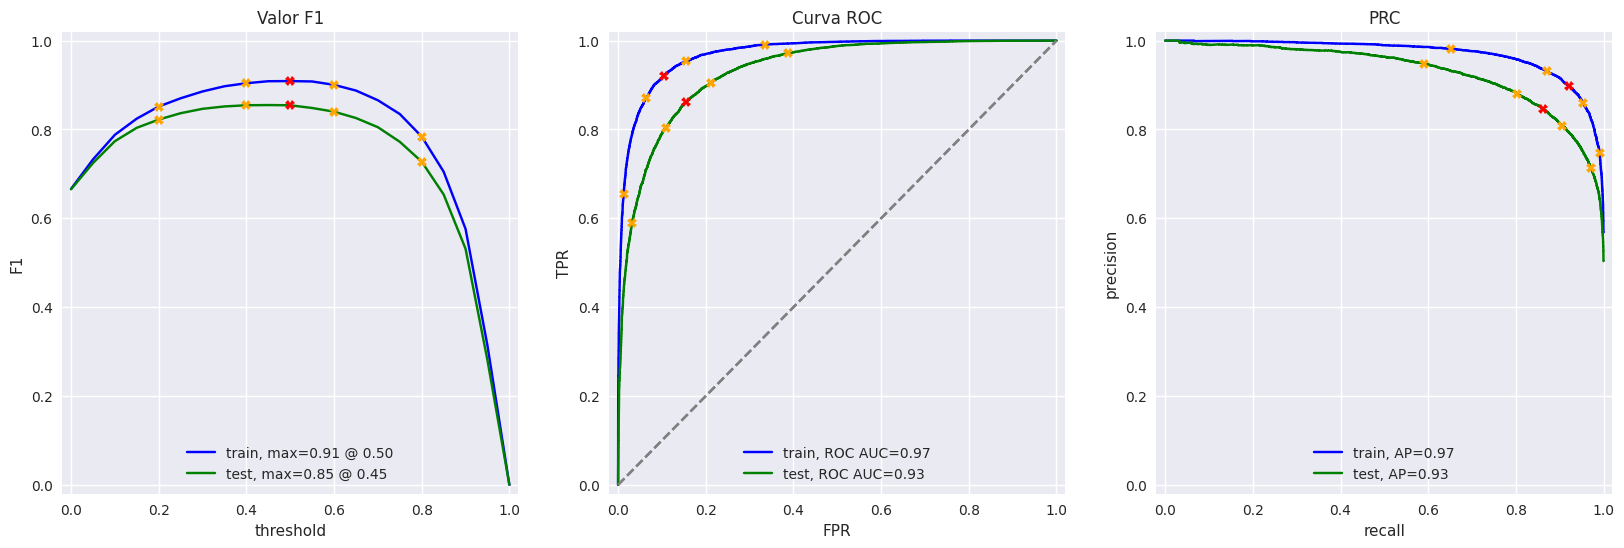

In [28]:
# Evaluación de desempeño del modelo 3: spaCy, TF-IDF y LGBM 
model_3_results = evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

El modelo 3 ha reducido ligeramente su desempeño en métricas, pero también ha disminuido el nivel de sobre ajuste en comparación con el modelo 1. A pesar de esto, sigue manteniendo un nivel muy competente en comparación con los modelos previos. Se recomendaría ajustar el umbral en 0.45 al utilizar el modelo 3 para obtener su mejor potencial.

###  4.5. Modelo 4 - BERT y LightGBM. <a id='m-4'></a>

El modelo 4 será el último modelo evaluado, consistirá en un preprocesamiento BERT con un tokenizado y ajuste con máscaras de atención. Se usará un modelo de potenciación de gradiente con LightGBM. Por cuestiones de costos de procesamiento, solo usaremos 500 reseñas en cada conjunto y evaluaremos el desempeño teniendo esto en cuenta.

In [29]:
# Importamos las nuevas librerías para el modelo 4
import torch
import transformers

In [30]:
# Instanciamos el tokenizador, el modelo y las configuraciones
transformers.logging.set_verbosity_error()
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [36]:
# Seccionamos 500 reseñas en cada conjunto.
train_sample_4 = df_reviews_train[['review_norm', 'pos']].sample(500, replace=False, random_state=12345)
test_sample_4 = df_reviews_test[['review_norm', 'pos']].sample(500, replace=False, random_state=12345)

train_corpus_4 = train_sample_4['review_norm']
test_corpus_4 = test_sample_4['review_norm']
train_target_4 = train_sample_4['pos']
test_target_4 = test_sample_4['pos']

In [37]:
# Definimos el embeding BERT para el vectorizado de textos
def BERT_text_to_embeddings(texts, max_length=512, batch_size=50, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [38]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
# en este caso solo lo usaremos para 500 textos, lo que toma solo algunos minutos
try:
    with np.load('features_4.npz') as data:
        train_features_4 = data['train_features_4']
        test_features_4 = data['test_features_4']
except:
    # Creación de las características de entrenamiento
    train_features_4 = BERT_text_to_embeddings(train_corpus_4)
    
    # Creación de las características de prueba
    test_features_4 = BERT_text_to_embeddings(test_corpus_4)
    
    # Almacenamiento
    np.savez_compressed('features_4.npz', train_features_4=train_features_4, test_features_4=test_features_4)


In [39]:
# Verificación del proceso de tokenización
print('Train:')
print(train_corpus_4.shape)
print(train_features_4.shape)
print(train_target_4.shape)
print('Test:')
print(test_corpus_4.shape)
print(test_features_4.shape)
print(test_target_4.shape)

Train:
(500,)
(500, 768)
(500,)
Test:
(500,)
(500, 768)
(500,)


In [40]:
# Entrenando el modelo de LightGBM
model_4 = LGBMClassifier()

model_4.fit(train_features_4, train_target_4)

LGBMClassifier()

          train  test
Accuracy    1.0  0.79
F1          1.0  0.78
APS         1.0  0.86
ROC AUC     1.0  0.86


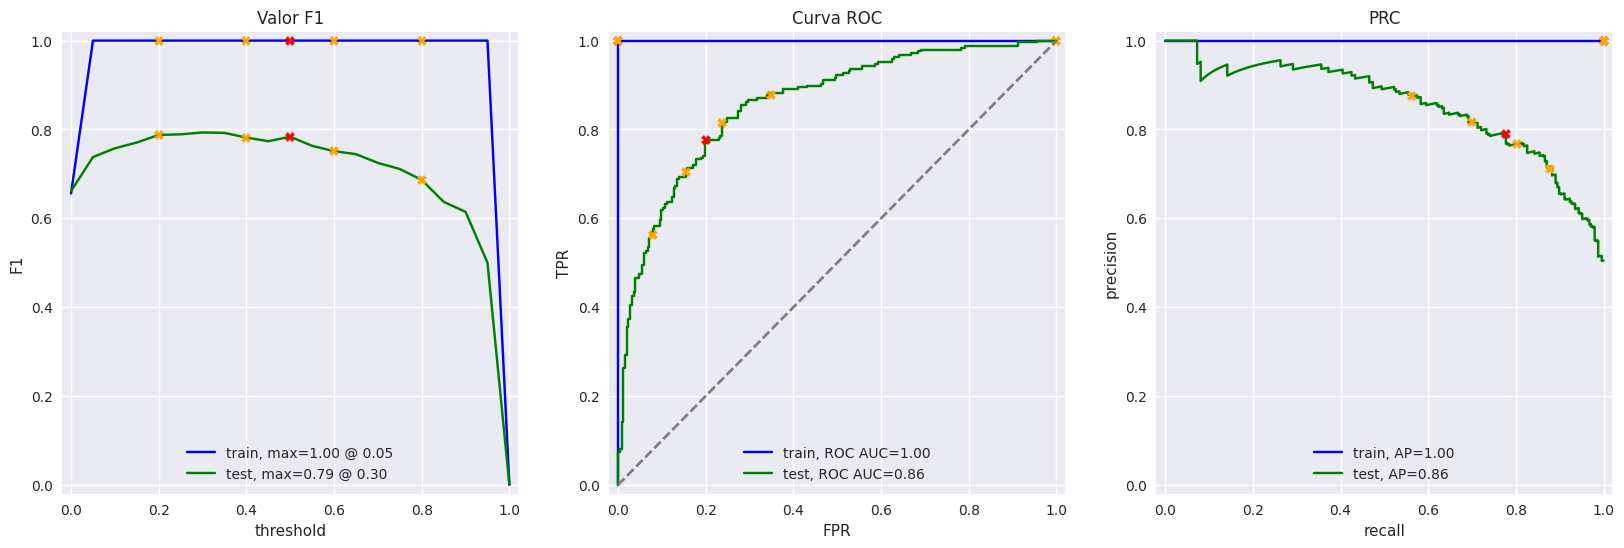

In [41]:
# Evaluación de desempeño del modelo 4: BERT y LightGBM
model_4_results = evaluate_model(model_4, train_features_4, train_target_4, test_features_4, test_target_4)

En nuestro último modelo hemos perdido calidad debido al recorte en los datos. Como podemos apreciar, también el sobre ajuste se marca pronunciadamente por la misma razón. Aun así, las métricas muestran un desempeño medio que probablemente, con el uso del potencial del dataset completo, obtendríamos resultados más prometedores, aunque debemos tener en cuenta el costo de cómputo elevado de este modelo. El umbral recomendado de este conjunto es de 0.3.

## 5. Pruebas adicionales para los modelos. <a id='test'></a> 

A continuación se pondrán a prueba los 4 modelos con un pequeño conjunto de reseñas generadas personalmente.

In [43]:
# Conjunto nuevo de reseñas.
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'Not expecting the ending, a perfect history for a friday night.',
    'Years waiting for the second part but it was a wasting of time. I don\'t kwon what was the director thinking.'
], columns=['review'])

# Normalización de los textos de reseñas
my_reviews['review_norm'] = my_reviews['review'].str.lower()
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x:clean_review_texts(x))

# Evaluacion personal de las reseñas.
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1, 1, 0]

my_reviews

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,1
8,"Not expecting the ending, a perfect history fo...",not expecting the ending a perfect history for...,1
9,Years waiting for the second part but it was a...,years waiting for the second part but it was a...,0


In [69]:
# Definiendo una función de evaluación para mis reseñas
def accuracy_my_reviews(threshold, model, my_reviews_features):
    # Realizando las predicciones    
    my_reviews_results = my_reviews[['pos']].copy()
    
    my_reviews_results['probability'] = np.round(model.predict_proba(my_reviews_features)[:, 1], 2)
    my_reviews_results['prediction'] = [0 if value < threshold else 1 for value in my_reviews_results['probability']]
    
    # Verificando las predicciones
    print(my_reviews_results)
    
    accuracy = metrics.accuracy_score(my_reviews_results['pos'], my_reviews_results['prediction'])
    print(f'La exactitud del modelo con las reseñas personalizadas fue: {accuracy}')
    return accuracy

### 5.1. Modelo 1. <a id='t-1'></a>

In [70]:
# Seleccionando el corpus
my_reviews_corpus = my_reviews['review_norm']

# Preparando las características
my_reviews_features_1 = count_tf_idf.transform(my_reviews_corpus)

# Precdicción y evaluación de resultados
acc_1 = accuracy_my_reviews(0.45, model_1, my_reviews_features_1)

   pos  probability  prediction
0    0         0.14           0
1    0         0.16           0
2    1         0.54           1
3    0         0.11           0
4    1         0.31           0
5    1         0.47           1
6    0         0.04           0
7    1         0.82           1
8    1         0.91           1
9    0         0.33           0
La exactitud del modelo con las reseñas personalizadas fue: 0.9


### 5.2. Modelo 2. <a id='t-2'></a>

In [73]:
# Preparando las características
my_reviews_features_2 = count_tf_idf_2.transform(my_reviews_corpus)

# Precdicción y evaluación de resultados
acc_2 = accuracy_my_reviews(0.5, model_2, my_reviews_features_2)

   pos  probability  prediction
0    0         0.16           0
1    0         0.07           0
2    1         0.50           1
3    0         0.14           0
4    1         0.23           0
5    1         0.39           0
6    0         0.03           0
7    1         0.90           1
8    1         0.88           1
9    0         0.53           1
La exactitud del modelo con las reseñas personalizadas fue: 0.7


### 5.3. Modelo 3. <a id='t-3'></a>

In [74]:
# Precdicción y evaluación de resultados
acc_3 = accuracy_my_reviews(0.45, model_3, my_reviews_features_2)

   pos  probability  prediction
0    0         0.51           1
1    0         0.26           0
2    1         0.56           1
3    0         0.39           0
4    1         0.62           1
5    1         0.51           1
6    0         0.31           0
7    1         0.73           1
8    1         0.84           1
9    0         0.62           1
La exactitud del modelo con las reseñas personalizadas fue: 0.8


### 5.4. Modelo 4. <a id='t-4'></a>

In [75]:
# Creación de las características
my_reviews_features_4 = BERT_text_to_embeddings(my_reviews_corpus)

# Precdicción y evaluación de resultados
acc_4 = accuracy_my_reviews(0.3, model_4, my_reviews_features_4)

Uso del dispositivo cpu.


  0%|          | 0/1 [00:00<?, ?it/s]

   pos  probability  prediction
0    0         0.03           0
1    0         0.07           0
2    1         0.02           0
3    0         0.05           0
4    1         0.01           0
5    1         0.99           1
6    0         0.01           0
7    1         0.81           1
8    1         0.31           1
9    0         0.02           0
La exactitud del modelo con las reseñas personalizadas fue: 0.8


## Conclusiones <a id='end'></a>

- Los modelos presentaron un desempeño similar en sus métricas, sin embargo, algunos modelos mostraron niveles de sobre ajuste altos, especialmente los entrenados con LightGBM.
- El modelo con mejor desempeño general en todas las evaluaciones fue el modelo 1 (NLTK, TF-IDF y LR) con un valor de F1 de 0.88, un sobre ajuste de 6 puntos (bajo) y una exactitud de 0.9 en el conjunto de reseñas personales.
- El modelo 4 tiene un alto potencial de mostrar mejores desempeños en el análisis de sentimiento si se utiliza el conjunto completo de entrenamiento; sin embargo, cuenta con una desventaja: el costo computacional y el tiempo de entrenamiento. Si estas variables no son una limitación, el modelo 4 podría superar el desempeño predictivo de los modelos aquí evaluados.